# Master Thesis Project
### Evaluation of an unsupervised learning approach for portfolio optimization

Created by Dario Sandrucci / Submitted on the 16.12.2022

Abstract:  
Throughout this directed research, we aim to identify opportunities for machine learning to support portfolio optimization. Based on a thorough literature review we decide to pursue an unsupervised learning approach and test its performance by conducting benchmarking against classic portfolio optimization techniques. To ensure the validity of our findings we explore the model’s robustness by conducting an array of experiments. In summary, we deem our version of the clustering algorithm to provide a suitable investment framework for return-focused investors with lower risk aversion. We suggest further research towards mitigating the algorithm’s inconsistencies and exploring additional tuning methodologies.

### 0. Import Packages

First lets import all functions and classes from we will need for our project. For a detailed description of the packages refer to the requirements file.

In [1]:
from data_engineering import *
from denoising_and_detoning import *
from algorithm import *
from portfolio_and_backtesting import *

### 1. Data Preparation and Exploration

In this part we will dowload the data and visualized some of the underlying features.

##### 1.1 Loading Data

We will utilize the returns of the 503 S&P500 component stocks. The data ranges throughout the period of the past 10 years, starting in November 2012. 

In [2]:
tickers = getTickers()
end = dt.fromisoformat('2022-11-17')
start = dt.fromisoformat('2012-11-17')
df = getData(start, end, tickers, downloaded = True)

Data was loaded sucessfully!


The input data is structured as follows. For 11 stocks we couldnt locate all data so for the purpose of this project we will these smaller component stocks.

In [3]:
df.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACGL,ACN,ADBE,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2012-11-20,-0.032791,0.034797,-0.001800,-0.008520,0.002703,-0.014194,0.002543,0.003011,-0.006412,-0.008505,...,0.010778,0.010209,-0.001148,-0.001939,-0.005137,0.011272,-0.012684,0.007293,0.006884,0.016235
2012-11-21,-0.012128,-0.001601,0.003606,0.001408,0.001225,0.005760,0.003963,0.011778,0.013958,0.006127,...,0.001142,0.010854,0.000766,0.005829,0.001807,0.008758,0.015748,-0.004072,0.008151,0.007489
2012-11-23,0.029018,0.002406,0.014244,0.017447,0.012974,0.020043,0.018001,0.005935,0.009177,0.017052,...,0.016356,0.012034,-0.004210,0.012271,0.012887,0.007103,0.006392,0.012267,0.018779,0.023786
2012-11-26,0.015998,0.033600,-0.011134,0.031549,0.001692,0.004211,-0.001706,0.007715,-0.007480,-0.003293,...,-0.005988,-0.016098,0.011145,-0.005275,-0.002036,0.013323,-0.005000,-0.010323,-0.004352,0.002420
2012-11-27,-0.003469,-0.015480,-0.019831,-0.008057,-0.005549,0.023760,-0.004661,-0.004278,-0.004729,-0.003304,...,0.000000,0.006414,0.005321,-0.014331,-0.008924,-0.008894,0.002309,-0.001965,-0.005143,-0.036214


##### 1.2 Data Visualization

A chart the shows the percentage returns over the period of the sample. We observe daily returns are concentrated around the mean of 0. Although most returns do not exceed the absolute 20% mark the dataset features a few outliers that hit returns beyond 70%.

Text(0.5, 1.0, 'Daily returns of S&P500 Stocks for Training Period')

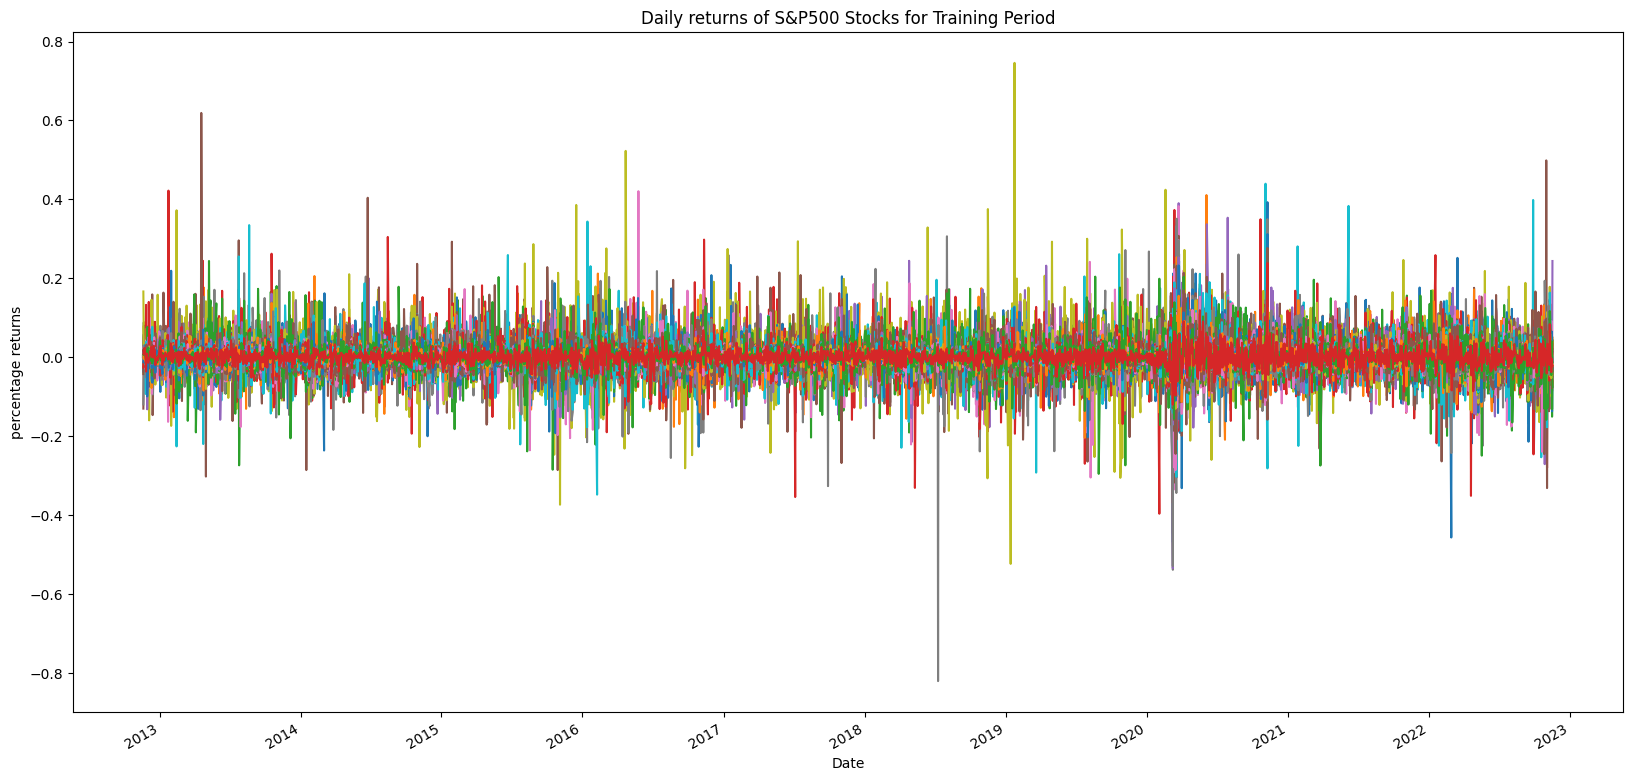

In [4]:
ax = df.plot(legend=False, figsize=(20,10))
ax.set_ylabel('percentage returns')
ax.set_title('Daily returns of S&P500 Stocks for Training Period')

To grasp a first idea of the data we are facing we plot the cummulative returns of the underlying S&P500 index over our sample period. Throughout the past 10 years we detect a mostly positive movement. Nevertheless, the recent market trends are rather negative, mostly driven by economic instability centered around the topic of inflation. Moreover, we can observe the negative spike in returns cause by covid in march 2020. 

Text(0.5, 1.0, 'Cummulative returns of the S&P 500 Index over the period of the data set')

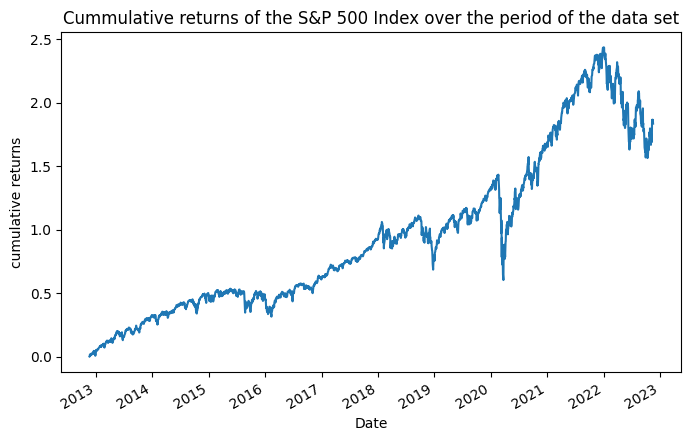

In [5]:
spy_returns = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
spy_returns = spy_returns.pct_change().dropna(axis = 0)
spy_cum = np.cumprod(1 + spy_returns) - 1
spy_cum.columns = ["S&P 500 Index"]

ax = spy_cum.plot(legend=False, figsize=(8,5))
ax.set_ylabel('cumulative returns')
ax.set_title('Cummulative returns of the S&P 500 Index over the period of the data set')

##### 1.3 Data Transformation

To train our alogrithm we split our dataset into three sets. The train and validation set will be used by the algorithm to learn and tune the model. The test set is a seperate set only touched after model implementation to evaluate model performance.

In [6]:
train_set_, test_set = testTrainSplit(df, validation_set = False, w_tt = [0.8, 0.2])
train_set, validation_set = testTrainSplit(train_set_, validation_set = False, w_tt = [0.75, 0.25])

### 2. Distance Metrics

##### 2.1. Derive the empirical correlation matrix

Our algorithm needs a distance matrix as input. To start we will derive the empirical correlation matrix.

In [7]:
stock_tickers  = train_set.columns 
corr0 = pd.DataFrame(getCorrMatrix(train_set), index = stock_tickers, columns = stock_tickers )

As we are utilizing a clustering algorithm a highrachchical cluster map helps us to understand how the stocks are behaving amogst each other.

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


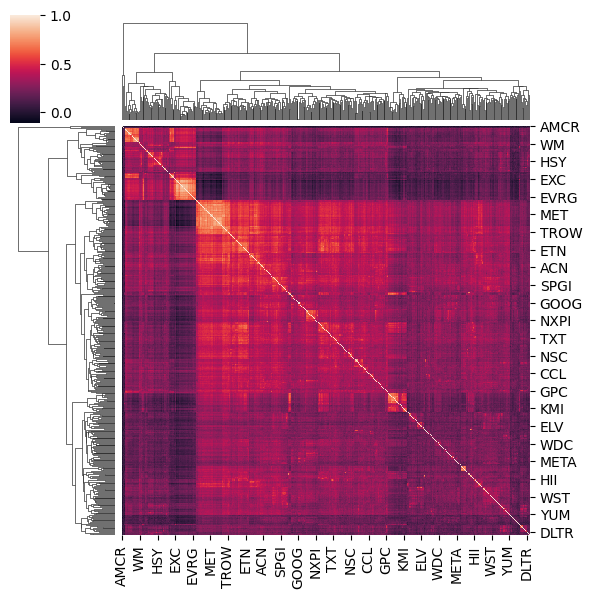

In [8]:
# Create a clustermap
sns.clustermap(corr0, method='average', figsize=(6,6))

##### 2.2 Denoise and Detone the Empirical correlation Matrix

Lets denoise the correlation matrix.

In [9]:
eVal0, eVec0, eVal1, eVec1, corr1, var0 = denoiseMatrix(corr0)
corr1 = pd.DataFrame(corr1, index = stock_tickers, columns = stock_tickers)

A plot to show the effect of the denoising of the eigen-function of our correlation matrix.

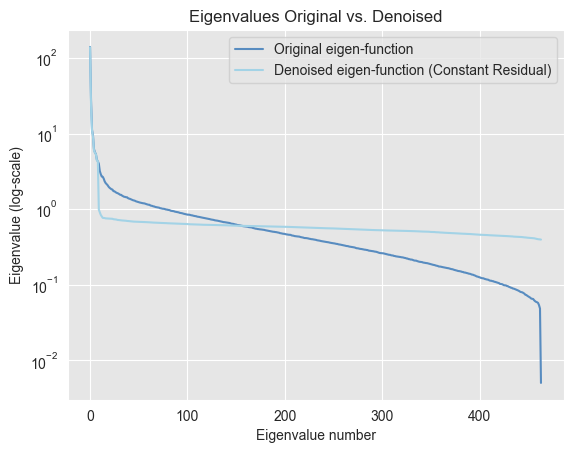

In [15]:
plotEvalDiff(eVal0, eVal1, palette = "RdYlBu_r", save = "Eigenvalues")

Next lets detone the correlation matrix. In essence we are removing the market common component out of all the stocks comovements.

In [16]:
corr2 = detoneMatrix(corr1, eVal1, eVec1)
corr2 = pd.DataFrame(corr2, index = stock_tickers, columns = stock_tickers)

We are now able to look at the empirical correlation matric after being denoised and detoned. We observe far fewer extreme values then in the initial version of the matrix. 

/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/seaborn/matrix.py:657: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


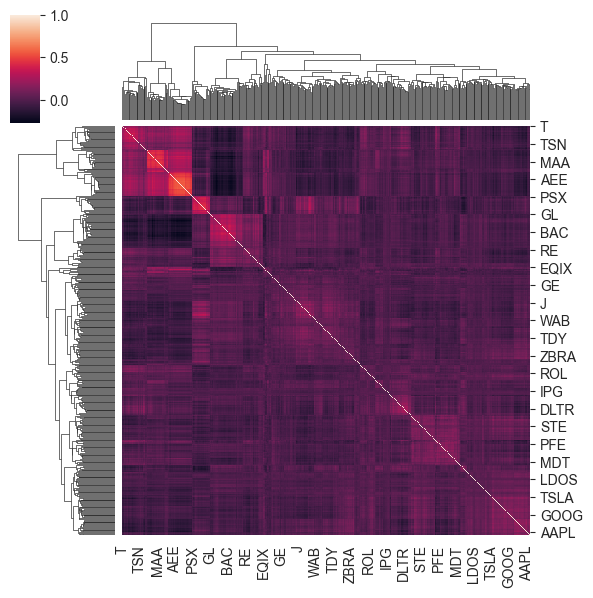

In [17]:
# Create a clustermap
sns.clustermap(corr2, method='average', figsize=(6,6))

##### 2.3. Minkowski distance

We will use the mikowski distance metric. Our denoised and detoned correlation matrix is transformed accordingly. Parameter p is specified within the pairwise_distances formula. In the furhter implementation throughout this report we will use the mikowski distance metric p_tuner function, built by us to use different p parameters and output the optimal value.

In [118]:
min_matrix0 = np.array(pairwise_distances(corr2, metric = "minkowski", p = 2))

### 3. Algorithm

In this section we quickly present the underlying algorithm that we developed frot the purpose of this project.

##### 3.1. Find optimal nuber of clusters in the dataset

The algorithm will use three methodologies to determine the optimal amount of clusters to be utilized by the clustering algorithm. The elbow method,silhouettes score and the davies boulding index. Below we exemplary present there results of the elbow method, one of the three methods for our base input matrix. The optimal number of clusters sits at the elbow/knee of the function. In our case the optimal number of clusters is 4.

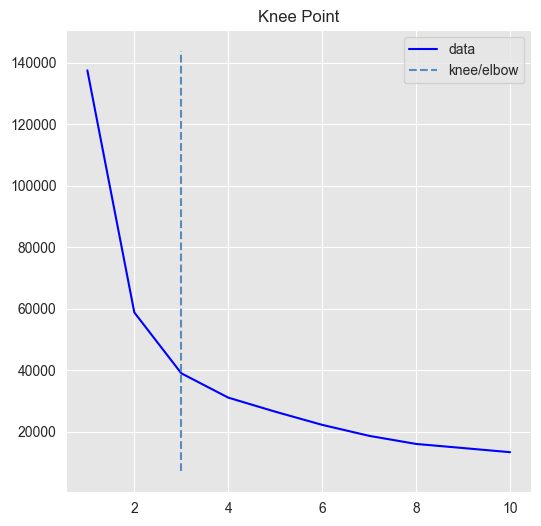

In [19]:
nr_clusters_sse = sse(min_matrix0)

##### 3.2. Running the clustering algorithm

Now that we have the optimal number of clusters we can run our algorithm. The algorithm utlizes the omega score. As threshold we will use the mean annualized return of the underlying index over the last 10 years. This will give us a solid benchmark for comparison. For a detailed description of the algorithms structure refer to the thesis report. The output is an array of the optimal portfolio allocation.

In [20]:
w = optPort_nco(train_set, min_matrix0, 4, 0.074, 50, 5)

In [21]:
#The first 3 weights
w[0:3]

array([0.00164441, 0.0035383 , 0.00018138])

##### 3.3 Distance metric tuning

In this section we want to evaluate whether special p-paramteters have a significant effect on model performance. Thus, we will implement the model of over different time periods with different different p parameters between 1 and 2. First lets define our time periods and possible p values.

In [4]:
p_values = [1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]

set1_, set2_ = testTrainSplit(df, False, w_tt = [0.5,0.5])
period1, period2, period3 = testTrainSplit(set1_, True, w_tvt = [0.33,0.33,0.34]) 
period4, period5, period6 = testTrainSplit(set2_, True, w_tvt = [0.33,0.33,0.34])
periods = [period1, period2, period3, period4, period5, period6]

Now lets implement a portfolio for each period and p parameter.

In [68]:
combined_min_ports = []
period_nr = 1

for period in periods:

    train, test = testTrainSplit(period, validation_set = False, w_tt = [0.8,0.2])
    corr_min = denoise_and_detone(train)
    min_ports = []

    for p in tqdm(p_values):
        min_matrix_ = np.array(pairwise_distances(corr_min, metric = "minkowski", p = p))
        nr_clusters_sse = sse(min_matrix_, graph = False)
        w_ = optPort_nco(train, min_matrix_, nr_clusters_sse, 0.074, 1000, 5)
        name = f"P = {p}; Per = {period_nr}"
        port = Portfolio(name, test, w_)
        min_ports.append(port)
    
    period_nr += 1
    
    combined_min_ports.append(min_ports)

100%|██████████| 11/11 [03:08<00:00, 17.10s/it]


In [69]:
p_reports = pd.DataFrame(0, index = [0], columns = ["ARet", "AVol", "Alpha", "p Alpha", "Beta","Sharpe", "Sortino", "IR", "MDD"])
for p in combined_min_ports:
    bm_min = PortfolioBenchmarking(p)
    rep = bm_min.performance_report(withSPY = False)
    p_reports = pd.concat([p_reports, rep])

p_reports = p_reports.drop(0, axis = 0)
p_values_new = p_values*6

Finally, lets run a cross sectional regression to identify the effect the p-parameters on model performance metrics. Our independant variable will be the p-parameter and the independant parameter the respecitve performance metric. 

In [70]:
r2s = {}
betas_p = {}
betas = {}

for m in p_reports.columns:
    
    r2 = round(regression(p_values_new, p_reports.loc[:,m].values)[4],4)
    pvalue_beta = round(regression(p_values_new, p_reports.loc[:,m].values)[3],4)
    beta = round(regression(p_values_new, p_reports.loc[:,m].values)[2],4)
    r2s[m] = r2
    betas_p[m] = pvalue_beta
    betas[m] = beta

In [71]:
r2s = pd.DataFrame(r2s, index = ["r2"]).transpose()
betas = pd.DataFrame(betas, index = ["beta"]).transpose()
betas_p = pd.DataFrame(betas_p, index = ["p-value beta"]).transpose()
significance = pd.merge(r2s,betas,how = "outer", left_index = True, right_index = True)
significance = pd.merge(significance,betas_p,how = "outer", left_index = True, right_index = True)

Here we can see the p-values of each cross sectional regression (one regression per performance metric).

In [72]:
significance

,r2,beta,p-value beta
ARet,0.0000,-0.0055,0.9734
AVol,0.0000,-0.0009,0.9875
Alpha,0.0000,-0.0000,0.9813
p Alpha,0.0027,0.0349,0.6794
Beta,0.0000,-0.0014,0.9793
Sharpe,0.0002,0.0438,0.9202
Sortino,0.0005,0.1474,0.8518
IR,0.0000,-0.0061,0.9895
MDD,0.0000,-0.0000,0.9979


### 4. Perfromance evaluation

#### 4.1. Benchmarking

We will compare our clustering portfolio with a few other common portfolio types, the mean-variance optimized (MVP), risk-parity (RPP), and equal-weighted portfolio (EWP), as well as the S&P index itself (SPY).

First let calculated the portfolio weights for our NCO algorithm. We will train our model on the train set and create a seperate validation set to tune the distance parameter p:

In [22]:
corr_train = denoise_and_detone(train_set)
corr_val = denoise_and_detone(validation_set)

Lets find the p parameter the yielded the highest sharpe ratio over the validation set and create to corresponding distance matrix.

In [25]:
opt_p = p_tuner(train_set, validation_set, corr_train, iter = 500)

100%|██████████| 11/11 [10:24<00:00, 56.73s/it]


In [26]:
min_matrix1 = np.array(pairwise_distances(corr_val, metric = "minkowski", p = opt_p))

lets finally calculate the final weight allocation over the validation set

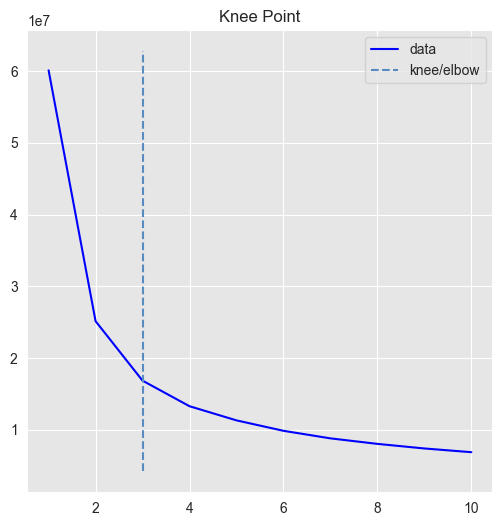

In [27]:
#Optimal number of clusters
nr_clusters_ = sse(min_matrix1)
#Clustering
w_NCO, cluster_NCO = optPort_nco(validation_set, min_matrix1, nr_clusters_, 0.074, 5000, 5, ret_clust = True)

Lets calculate the allocations for some other benchmark portflios.

In [28]:
#EW
w_EW = np.ones(len(train_set_.columns))
w_EW /= [len(train_set_.columns)]*len(train_set_.columns)
#MVO
w_MVO = optPortMVO(train_set_)
#RPP
w_RPP = optPortRPP(train_set_)

Not lets build the portfolios over the test set:

In [29]:
#building the single portfolios
port_NCO = Portfolio(f"NCO", test_set, w_NCO)
port_EWP = Portfolio("EWP", test_set, w_EW)
port_MVO = Portfolio("MVO", test_set, w_MVO)
port_RPP = Portfolio("RPP", test_set, w_RPP)
#comparing the portfolios
BM1 = PortfolioBenchmarking([port_NCO, port_EWP, port_MVO, port_RPP], "NCO vs. Classic Portfolios")

We are ready to perform some comparisons:

Cummulative returns:

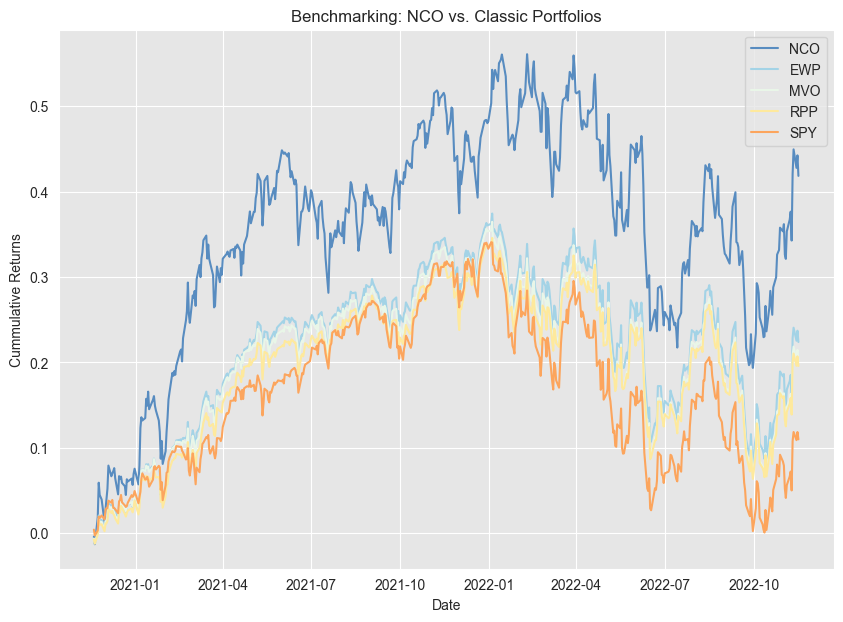

In [31]:
BM1.plot_performance(palette = "RdYlBu_r", save = "Base_Benchmarking")

The portfolios' performance metrics:

In [ ]:
rp = BM1.performance_report(return_value = True)

In [33]:
pl = sns.light_palette("green", as_cmap = True)
rl = sns.light_palette("red", as_cmap = True)
rp = rp.fillna(0)
rp.style\
    .background_gradient(cmap = pl, subset = ["ARet"], vmin = 0.1)\
    .background_gradient(cmap = pl, subset = ["Sharpe"], vmin = 0.6)\
    .background_gradient(cmap = pl, subset = ["Sortino","IR"], vmin = 0.8)\
    .background_gradient(cmap = pl, subset = ["MDD"], vmin = -0.072)\
    .background_gradient(cmap = rl, subset = ["AVol"])

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
SPY,0.070600,0.190900,0.000000,0.961700,1.000000,0.369800,0.524500,0.000000,-0.075300
NCO,0.206200,0.248800,0.000500,0.169100,1.077500,0.828500,1.356000,1.006900,-0.090400
EWP,0.118600,0.186400,0.000200,0.138300,0.931900,0.636300,0.942800,0.948400,-0.071400
MVO,0.109300,0.184700,0.000200,0.168100,0.930500,0.592000,0.871800,0.861000,-0.070300
RPP,0.105600,0.178500,0.000200,0.186400,0.896100,0.591300,0.864300,0.752000,-0.069500


Correlation between the portfolios' returns.

In [88]:
BM1.cum_returns.corr()

,NCO p = 1.0,EWP,MVO,RPP,S&P 500 Index
NCO p = 1.0,1.000000,0.955480,0.940494,0.942174,0.838105
EWP,0.955480,1.000000,0.998584,0.999028,0.936326
MVO,0.940494,0.998584,1.000000,0.999547,0.946990
RPP,0.942174,0.999028,0.999547,1.000000,0.944819
S&P 500 Index,0.838105,0.936326,0.946990,0.944819,1.000000


##### 4.2. Robustness Analysis

In this subchapter we test our models robustness through various experiments.

##### 4.2.1 Cluster persistatance

We will take a look at the rebalanced portfolio and see whether the components of the clusters that found be the algorithm persist with time.

Experiment 1: Static Persistence

In [ ]:
clusters_NCO = []
for i in tqdm(range(50)):
    mat = pd.DataFrame(min_matrix0)
    nrc = sse(mat, graph = False)
    _, clusters, _ = clusterKMeansBase(mat, nrc)
    clusters_NCO.append(clusters)

100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


In [ ]:
pc1 = persistance_counter(clusters_NCO)

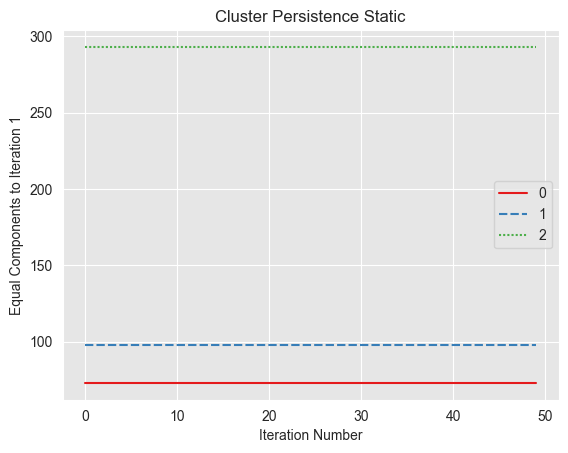

In [ ]:
sns.set_palette("Set1")
plt.figure()
sns.lineplot(pd.DataFrame(pc1))
plt.xlabel("Iteration Number")
plt.ylabel("Equal Components to Iteration 1")
plt.title("Cluster Persistence Static")
#plt.savefig("figures/persistence1.png")

Experiment2: Persitence over time

In [ ]:
pc2 = persistance_counter(clusters_RB)

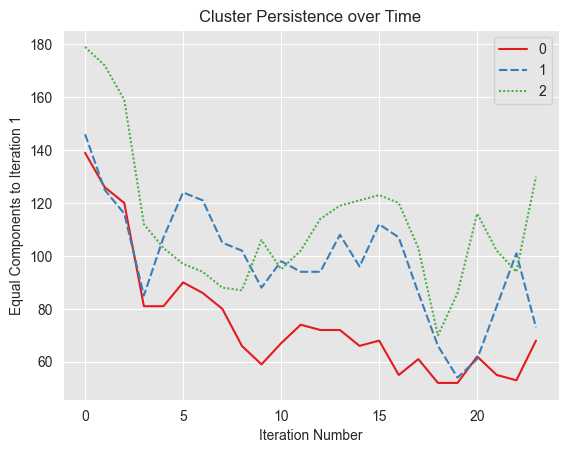

In [ ]:
plt.figure()
sns.lineplot(pd.DataFrame(pc2))
plt.xlabel("Iteration Number")
plt.ylabel("Equal Components to Iteration 1")
plt.title("Cluster Persistence over Time")
#plt.savefig("figures/persistence2.png")

##### 4.2.2 Time dimensioning

Let discover the effect of different train-test split layouts on the model performance. The are 2 parateter that we will explore. The ratio of train and test split and the overall sample size.

Experiment 1: Different investment periods

Lets create an investments in 6 different investement period an discover whether our results hold up.

In [34]:
#lets create the corresponding investment train and test set_yscale
set1_, set2_ = testTrainSplit(df, False, w_tt = [0.5,0.5])
period1, period2, period3 = testTrainSplit(set1_, True, w_tvt = [0.33,0.33,0.34]) 
period4, period5, period6 = testTrainSplit(set2_, True, w_tvt = [0.33,0.33,0.34])
periods = [period1, period2, period3, period4, period5, period6]

low lets implement our model for all periods and compare

In [88]:
per = 1

reports = {}

for p in periods:

    #generate train val test split
    train_set0, val_set0, test_set0 = testTrainSplit(p, True , w_tvt = [0.6,0.2,0.2])

    #set threshold for omega score
    aret_mkt = 0.074

    #build correlations matricies
    corr_train = denoise_and_detone(train_set0)
    corr_val = denoise_and_detone(val_set0)

    #retriev optimal p parameter
    p_opt_ = p_tuner(train_set0, val_set0, corr = corr_train, th = aret_mkt, iter = 50)

    #implement tuned distance matrix
    min_matrix2 = np.array(pairwise_distances(corr_val, metric = "minkowski", p = p_opt_))

    #get optimal number of clusteres
    nr_clusters_ = sse(min_matrix2, graph = False)

    #calculate optimal portfolio allocation
    w_NCO_, cluster_NCO_ = optPort_nco(val_set0, min_matrix2, nr_clusters_, aret_mkt, 5000, 5, ret_clust = True)    

    #build portfolio
    port_NCO_ = Portfolio(f"NCO Period {per}", test_set0, w_NCO_)

    #generate performance report
    name, pr = port_NCO_.performance_report(True)

    #calculate SPY portfolio as benchmark
    start  = test_set0.index[0] - timedelta(days = 1)
    end  = test_set0.index[len(test_set0.index)-1]
    mkt_returns_ = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
    mkt_returns_ = mkt_returns_.pct_change().dropna(axis = 0)
    mkt = Portfolio_Ret(f"SPY Period {per}", mkt_returns_.loc[:,"SPY"])
    mkt_n, mkt_pr = mkt.performance_report(True)

    #append performances of NCO and SPY to the dataframe
    reports[name] = pr
    reports[mkt_n] = mkt_pr

    #next period
    per += 1

reports = pd.DataFrame(reports, index = ["ARet", "AVol", "Alpha", "p Alpha", "Beta","Sharpe", "Sortino", "IR", "MDD"])

100%|██████████| 11/11 [00:51<00:00,  4.65s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [00:45<00:00,  4.18s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [00:45<00:00,  4.17s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [00:43<00:00,  3.98s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in doub

Lets look at the different performance metrics.

In [89]:
reports = reports.transpose().fillna(0)
reports

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
NCO Period 1,0.1888,0.1078,-0.0001,0.5486,1.1304,1.7510,2.2673,-0.3549,-0.0362
SPY Period 1,0.1847,0.0906,-0.0000,0.0797,1.0000,2.0373,2.5936,0.0000,-0.0318
NCO Period 2,-0.1111,0.2755,0.0002,0.8417,1.2683,-0.4031,-0.6951,0.1060,-0.0671
SPY Period 2,-0.1269,0.1865,-0.0000,0.3665,1.0000,-0.6806,-1.0973,0.0000,-0.0444
NCO Period 3,0.2934,0.1003,0.0003,0.4684,1.3700,2.9259,3.6533,2.2194,-0.0348
SPY Period 3,0.1642,0.0619,0.0000,0.0458,1.0000,2.6526,2.8387,0.0000,-0.0255
NCO Period 4,0.1412,0.1574,-0.0004,0.3091,1.2767,0.8975,1.1600,-0.7968,-0.0548
SPY Period 4,0.1946,0.1142,-0.0000,0.0000,1.0000,1.7034,2.0934,0.0000,-0.0370
NCO Period 5,1.1311,0.3079,0.0026,0.1535,1.1504,3.6736,9.8748,2.8107,-0.1395
SPY Period 5,0.4116,0.1500,0.0000,0.0000,1.0000,2.7437,4.0880,0.0000,-0.0468


Experiment 2: Different Train Test Ratios

We will implement 7 different portfolios with different train-test split ratios and evaulate whether the split rations have and impact on performance metrics.

In [36]:
ratios = [[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6,0.4],[0.75,0.25],[0.9,0.1]]

In [37]:
reports2 = {}

for r in ratios:

    #split weights
    w_tvt0 = [(r[0]/4)*3,(r[0]/4),r[1]]

    #build the train val test sets
    train_set1, val_set1, test_set1 = testTrainSplit(df, True , w_tvt = w_tvt0)

    #set omega threshold
    th = 0.074

    #build correlation matricies
    corr_train = denoise_and_detone(train_set1)
    corr_val = denoise_and_detone(val_set1)

    #calculate optimal p parameter
    p_opt0 = p_tuner(train_set1, val_set1, corr_train, th = th, iter = 500)

    #set tuned distance matrix
    min_matrix3 = np.array(pairwise_distances(corr_val, metric = "minkowski", p = p_opt0))

    #optimal number of clusters
    nr_clusters_ = sse(min_matrix3, graph = False)
    
    #portfolio allocation
    w_NCO_, cluster_NCO_ = optPort_nco(val_set1, min_matrix3, nr_clusters_, th, 5000, 5, ret_clust = True)    

    #building portfolio
    port_NCO_ = Portfolio(f"NCO Split {r}", test_set1, w_NCO_)

    #create performance report
    name, pr = port_NCO_.performance_report(True)

    #create SPY benchmark portfolio
    start  = test_set1.index[0] - timedelta(days = 1)
    end  = test_set1.index[len(test_set1.index)-1]
    mkt_returns_ = pdr.get_data_yahoo(["SPY"], start, end)["Close"]
    mkt_returns_ = mkt_returns_.pct_change().dropna(axis = 0)
    mkt = Portfolio_Ret(f"SPY Split {r}", mkt_returns_.loc[:,"SPY"])
    mkt_n, mkt_pr = mkt.performance_report(True)

    #appaned reports to dataframe
    reports2[name] = pr
    reports2[mkt_n] = mkt_pr

reports2 = pd.DataFrame(reports2, index = ["ARet", "AVol", "Alpha", "p Alpha", "Beta","Sharpe", "Sortino", "IR", "MDD"])    

100%|██████████| 11/11 [01:35<00:00,  8.72s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [03:01<00:00, 16.51s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [05:06<00:00, 27.86s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
100%|██████████| 11/11 [06:20<00:00, 34.56s/it]
/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in doub

Let look at the different performance metrics.

In [64]:
reports2 = reports2.transpose().fillna(0)
reports2

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
"NCO Split [0.1, 0.9]",0.1591,0.2091,0.0002,0.0395,1.1128,0.7612,0.9305,0.8325,-0.2176
"SPY Split [0.1, 0.9]",0.1041,0.1791,0.0000,0.0000,1.0000,0.5810,0.6917,0.0000,-0.1949
"NCO Split [0.25, 0.75]",0.1523,0.2494,0.0001,0.4062,1.1845,0.6108,0.7726,0.4521,-0.2401
"SPY Split [0.25, 0.75]",0.1007,0.1895,-0.0000,0.0000,1.0000,0.5315,0.6301,0.0000,-0.1949
"NCO Split [0.4, 0.6]",0.1568,0.2583,0.0001,0.7194,1.1785,0.6071,0.7542,0.3219,-0.2408
"SPY Split [0.4, 0.6]",0.1192,0.1977,0.0000,0.1480,1.0000,0.6027,0.7016,0.0000,-0.1949
"NCO Split [0.5, 0.5]",0.1232,0.3125,-0.0000,0.8924,1.2323,0.3942,0.5211,0.0861,-0.2857
"SPY Split [0.5, 0.5]",0.1082,0.2143,-0.0000,0.5097,1.0000,0.5048,0.6029,0.0000,-0.1949
"NCO Split [0.6, 0.4]",0.2419,0.2859,0.0004,0.0222,1.1789,0.8462,1.0812,1.2680,-0.2074
"SPY Split [0.6, 0.4]",0.1228,0.2284,0.0000,0.0025,1.0000,0.5375,0.6478,0.0000,-0.1949


##### 4.2.3 Rebalacing

Let discover the effect of rebalacing on the porfolio performance.

In [38]:
#set investment start
investment_start = test_set.index[0]
investment_start

Timestamp('2020-11-18 00:00:00')

Lets implement our rebalanced portfolio with the set investment start.

In [39]:
# potfolio with rebalacing
ret_RB, clusters_RB = optPort_nco_RB(df, investment_start, 5000, ret_clust = True, tuneIter = 5000)

100%|██████████| 11/11 [01:04<00:00,  5.87s/it]


In [74]:
port_NCOMO_RB = Portfolio_Ret("NCO Monthly Rebalanced", ret_RB.iloc[:len(ret_RB)-1])

In [75]:
bm4 = PortfolioBenchmarking([port_NCOMO_RB, port_NCO])

Lets have a look a cummulative returns:

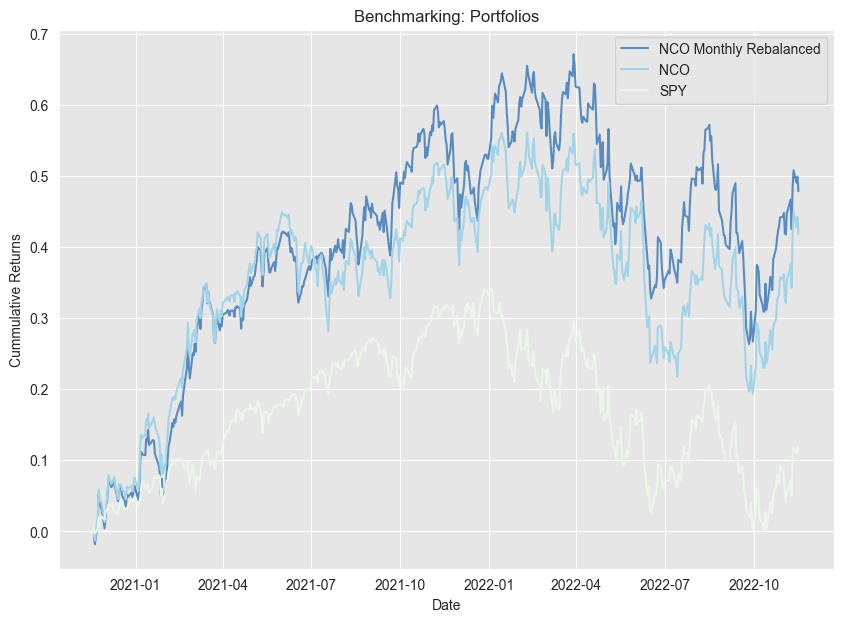

In [91]:
bm4.plot_performance(save = "StaticvsReb")

Performance metrics:

In [87]:
rp4 = bm4.performance_report(return_value = True).fillna(0)
rp4.style\
    .background_gradient(cmap = pl, subset = ["ARet"], vmin = 0.18)\
    .background_gradient(cmap = pl, subset = ["Sharpe"], vmin = 0.7)\
    .background_gradient(cmap = pl, subset = ["Sortino"], vmin = 1)\
    .background_gradient(cmap = pl, subset = ["IR"], vmin = 0.8)\
    .background_gradient(cmap = pl, subset = ["MDD"], vmin = -0.09, vmax = 0)\
    .background_gradient(cmap = rl, subset = ["AVol"], vmin = 0.235, vmax = 0.248)

/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))
/Users/dario/Desktop/Projects/thesis/algorithm/thesis_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
SPY,0.070600,0.190900,0.000000,0.961700,1.000000,0.369800,0.524500,0.000000,-0.075300
NCO Monthly Rebalanced,0.225300,0.242100,0.000600,0.124000,1.009100,0.930500,1.506200,1.097000,-0.088800
NCO,0.206200,0.248800,0.000500,0.169100,1.077500,0.828500,1.356000,1.006900,-0.090400


##### 4.2.3 Application in a different market environment

For compareable data we will use the components of the Jakarta Composite Index. We will perform the same steps as in our base alogrithm for the S&P500

In [40]:
#load the data 
df_tyo = pd.read_csv("data/nikkei225comps.csv")
df_tyo = df_tyo.set_index("Date").pct_change().iloc[1:]
df_tyo.index = pd.to_datetime(df_tyo.index)

In [41]:
#create train test splits and derive the denoised and detoned correlation matrix
train_set_tyo_, test_set_tyo = testTrainSplit(df_tyo, validation_set = False, w_tt = [0.8, 0.2])
train_set_tyo, val_set_tyo = testTrainSplit(train_set_tyo_, validation_set = False, w_tt = [0.5, 0.5])
corr2_tyo = denoise_and_detone(train_set_tyo)

In [42]:
#optimal p parameter
pv_tyo = p_tuner(train_set_tyo, val_set_tyo, corr2_tyo, iter = 500)

100%|██████████| 11/11 [03:30<00:00, 19.13s/it]


In [43]:
#derive the tuned distance matrix
corr2_tyo_val = denoise_and_detone(val_set_tyo)
min_matrix_tyo = np.array(pairwise_distances(corr2_tyo_val, metric = "minkowski", p = pv_tyo))

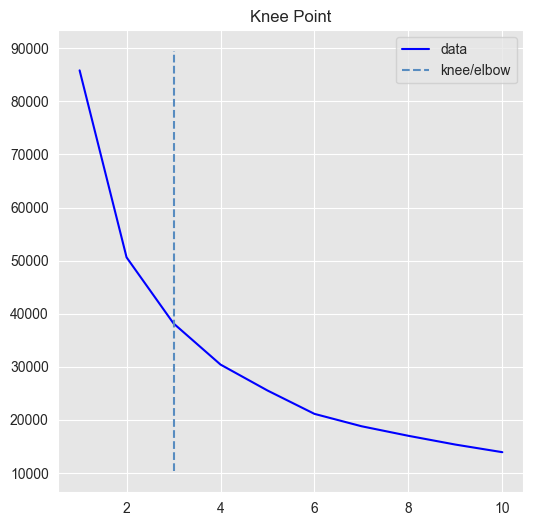

In [94]:
#Optimal number of clusters
nr_clusters_tyo = sse(min_matrix_tyo)
#Clustering
w_NCO_tyo, cluster_NCO_tyo = optPort_nco(val_set_tyo, min_matrix_tyo, nr_clusters_tyo, 0.074, 5000, 5, ret_clust = True)

In [45]:
# Jakarta Composite Index
nikkei225_ret = pdr.get_data_yahoo(["^N225"], test_set_tyo.index[0], end)["Close"].pct_change()[1:len(test_set_tyo)]
nikkei225_ret = pd.Series(nikkei225_ret.values.reshape(-1), index = nikkei225_ret.index)
nikkei225_port = Portfolio_Ret("Nikkei225 Index", nikkei225_ret)

In [46]:
#EW
w_EW_tyo = np.ones(len(train_set_tyo_.columns))
w_EW_tyo /= [len(train_set_tyo_.columns)]*len(train_set_tyo_.columns)
#MVO
w_MVO_tyo = optPortMVO(train_set_tyo_)
#RPP
w_RPP_tyo = optPortRPP(train_set_tyo_)

In [139]:
#building the single portfolios
port_NCO_tyo = Portfolio(f"NCO Nikkei225", test_set_tyo.iloc[1:], w_NCO_tyo)
port_EWP_tyo = Portfolio("EWP Nikkei225", test_set_tyo.iloc[1:], w_EW_tyo)
port_MVO_tyo = Portfolio("MVO Nikkei225", test_set_tyo.iloc[1:], w_MVO_tyo)
port_RPP_tyo = Portfolio("RPP Nikkei225", test_set_tyo.iloc[1:], w_RPP_tyo)
#comparing the portfolios
BM5 = PortfolioBenchmarking([port_NCO_tyo, port_EWP_tyo, port_MVO_tyo, port_RPP_tyo, nikkei225_port], "NCO vs. Classic Nikkei255 Portfolios")

Now lets compare the results. First lets view the cummulative returns:

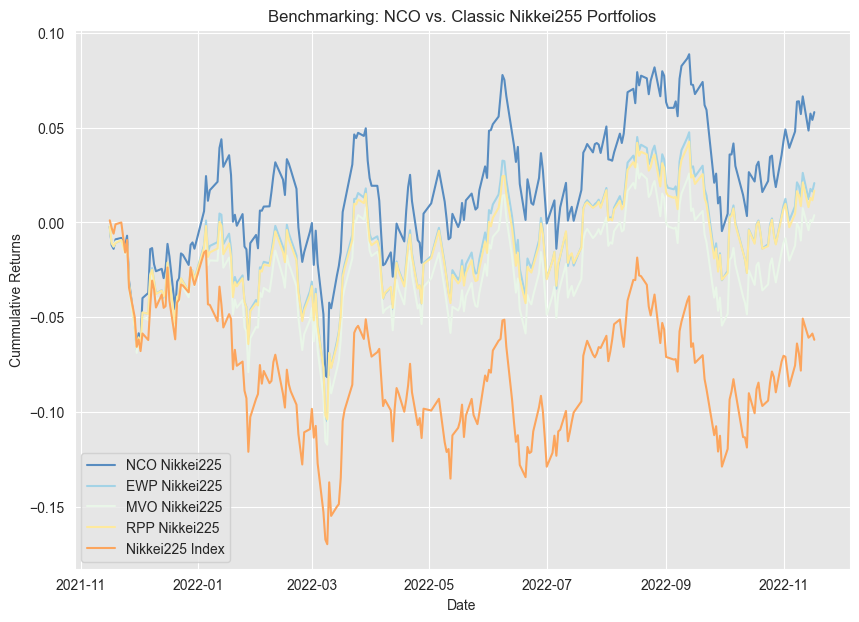

In [141]:
BM5.plot_performance(False, save = "Japan")

In [97]:
bm5 = BM5.performance_report(return_value = True, withSPY = False, bm = "^N225")

/Users/dario/Desktop/Projects/thesis/algorithm/portfolio_and_backtesting.py:116: RuntimeWarning: invalid value encountered in double_scalars
  information_ratio = (return_difference.mean() * 252) / (volatility * np.sqrt(252))


Performance metrics:

In [115]:
bm5.fillna(0).style\
    .background_gradient(cmap = pl, subset = ["ARet"], vmin = 0.01)\
    .background_gradient(cmap = pl, subset = ["Sharpe"], vmin = 0.15)\
    .background_gradient(cmap = pl, subset = ["Sortino"], vmin = 0.2)\
    .background_gradient(cmap = pl, subset = ["IR"], vmin = 0.8)\
    .background_gradient(cmap = pl, subset = ["MDD"], vmin = -0.08, vmax = 0)\
    .background_gradient(cmap = rl, subset = ["AVol"])

,ARet,AVol,Alpha,p Alpha,Beta,Sharpe,Sortino,IR,MDD
NCO Nikkei225,0.076300,0.191900,0.000400,0.275900,0.785600,0.397800,0.633400,1.098600,-0.079100
EWP Nikkei225,0.036900,0.178200,0.000300,0.326500,0.782900,0.206900,0.341600,0.955700,-0.070400
MVO Nikkei225,0.020400,0.181800,0.000200,0.364800,0.820500,0.112200,0.186400,0.896300,-0.070000
RPP Nikkei225,0.031800,0.171900,0.000300,0.337100,0.759800,0.184900,0.308600,0.907300,-0.067600
Nikkei225 Index,-0.043800,0.208600,-0.000000,0.512700,1.000000,-0.209900,-0.348100,0.000000,-0.069400
